In [1]:
import river
import pandas as pd
from kafka import KafkaConsumer
from river import datasets, compose, preprocessing, linear_model, metrics, drift
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import joblib

np.random.seed(42)

## Testing static and dynamic models and retraining dynamic model-Plotting F1 score of static model and dynamic model

F1 Score static 0.6666666666666667
Precision Score static 0.7307692307692307
Recall Score static: 0.6129032258064516

F1 Score dynamic 0.6666666666666667
Precision Score dynamic 0.7307692307692307
Recall Score dynamic: 0.6129032258064516

Retrain the Model
F1 Score static 0.6606060606060606
Precision Score static 0.7299107142857143
Recall Score static: 0.6033210332103321

F1 Score dynamic 0.8492063492063492
Precision Score dynamic 0.745125348189415
Recall Score dynamic: 0.9870848708487084

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.6653102746693794
Precision Score static 0.7431818181818182
Recall Score static: 0.6022099447513812

F1 Score dynamic 0.8343750000000001
Precision Score dynamic 0.7245590230664858
Recall Score dynamic: 0.9834254143646409

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.6679764243614932
Precision Score static 0.748898678414097
Recall Score static: 0.6028368794326241

F1 Score dynamic 0.8547140649149924
Precision Score dynamic 0.7575342465753425
Recall Score dynamic: 0.9804964539007093

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.64375
Precision Score static 0.7202797202797203
Recall Score static: 0.5819209039548022

F1 Score dynamic 0.8325203252032521
Precision Score dynamic 0.7324749642346209
Recall Score dynamic: 0.9642184557438794

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.703125
Precision Score static 0.782608695652174
Recall Score static: 0.6382978723404256

F1 Score dynamic 0.8501152959262106
Precision Score dynamic 0.7503392130257802
Recall Score dynamic: 0.9804964539007093

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.6647058823529411
Precision Score static 0.7337662337662337
Recall Score static: 0.6075268817204301

F1 Score dynamic 0.8460943542150039
Precision Score dynamic 0.7442176870748299
Recall Score dynamic: 0.9802867383512545

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.662013958125623
Precision Score static 0.7328918322295805
Recall Score static: 0.6036363636363636

F1 Score dynamic 0.8448947778643803
Precision Score dynamic 0.7394270122783083
Recall Score dynamic: 0.9854545454545455

Retrain the Model


C:\ProgramData\anaconda3\envs\online\lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


F1 Score static 0.6551059730250482
Precision Score static 0.753880266075388
Recall Score static: 0.5792163543441227

F1 Score dynamic 0.860759493670886
Precision Score dynamic 0.7645502645502645
Recall Score dynamic: 0.9846678023850085

Don't retrain


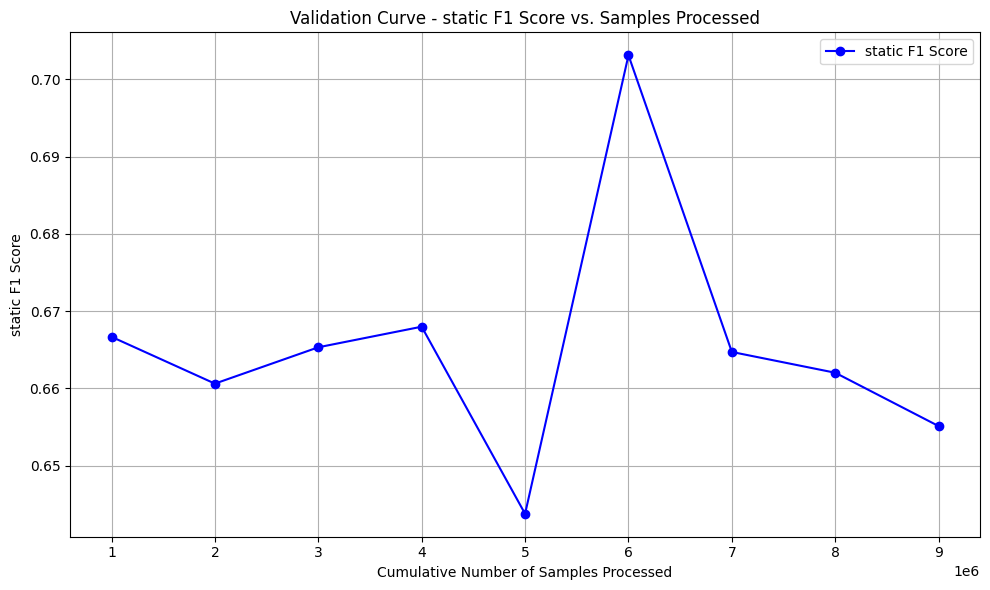

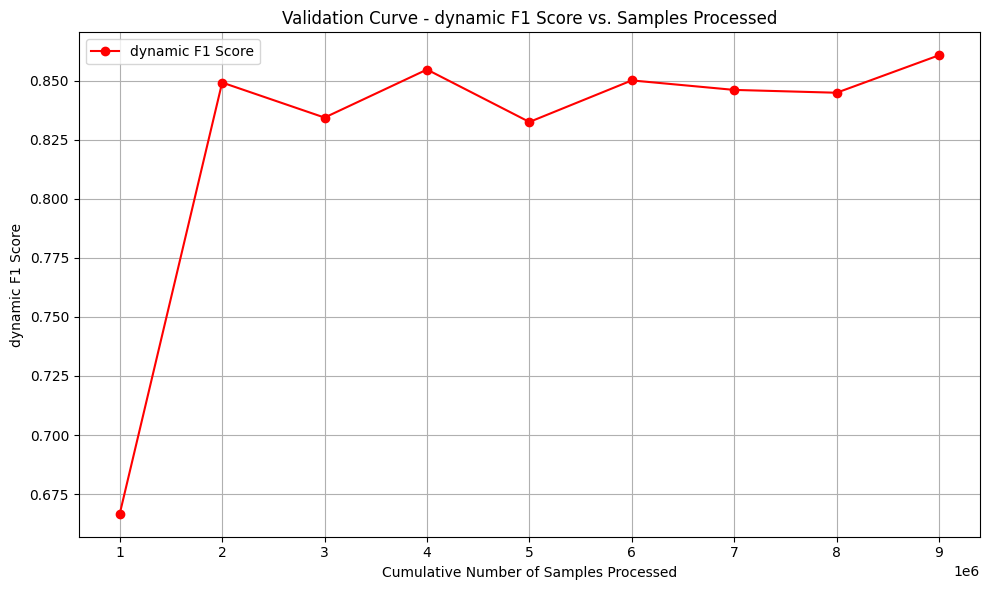

In [13]:
from json import loads
from river.utils.vectordict import VectorDict
from sklearn.metrics import f1_score
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    value_deserializer=lambda x: loads(x.decode('ISO-8859-1'))
)

# model_static = joblib.load('static_model5.pkl')
pkl_filename = 'final_model_static.pkl'
with open(pkl_filename, 'rb') as file:
    model_dynamic = pickle.load(file)
    model_dynamic.set_params(warm_start=True)
    model_dynamic.n_estimators +=200

with open(pkl_filename, 'rb') as file:
    model_static = pickle.load(file)
    model_static.set_params(warm_start=False)

indexes_to_drop = np.load('dropped_feature_indices.npy')


c = 0
dataFrame = pd.DataFrame()
columns = ['FQDN_count', 'subdomain_length', 'upper', 'lower', 'numeric', 'entropy', 'special', 'labels',
                'labels_max', 'labels_average', 'longest_word', 'sld', 'len', 'subdomain', 'Target Attack']
window = 1000
threshold = 0.86
f1_static = []
f1_dynamic = []
precision_static = []
precision_dynamic = []
recall_static = []
recall_dynamic = []

f1_static_values = []
f1_dynamic_values = []
cumulative_sample_counts = []

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

for row in consumer:
    
    if c == 0:
        pass
        
    else:
       
        data = row.value
        data = data[:-1]
        data = data.split(",")
        data = data[1:]
        
        
        filtered_data = {key: value for key, value in zip(columns, data)}
        filtered_data = pd.DataFrame([filtered_data], columns=columns)
        filtered_data = filtered_data.dropna(axis=1)
        
        filtered_data.loc[:,'longest_word'] = filtered_data.loc[:,'longest_word'].apply(hash)
        filtered_data.loc[:,'sld'] = filtered_data.loc[:,'sld'].apply(hash)
        filtered_data = filtered_data.drop(filtered_data.columns[indexes_to_drop], axis=1)

        exclude_columns = ['Target Attack']

        
        for col in filtered_data.columns:
                  if col not in exclude_columns:
                            filtered_data[col] = pd.to_numeric(filtered_data[col], errors='coerce').astype(float)
        
        
        dataFrame = pd.concat([dataFrame, filtered_data], axis=0)
        
        if dataFrame.shape[0]==window:
            X = dataFrame.iloc[:,:-1]
            X = sc.fit_transform(X)
            
            y = dataFrame.iloc[:,-1].astype(int)

            y_pred_static = model_static.predict(X)
            f1_static.append(f1_score(y,y_pred_static))
            print('F1 Score static',f1_score(y,y_pred_static))

            precision_static.append(precision_score(y,y_pred_static))
            print('Precision Score static',precision_score(y,y_pred_static))

            recall_static.append(recall_score(y,y_pred_static))
            print(f'Recall Score static: {recall_score(y,y_pred_static)}\n')

            
            y_pred_dynamic = model_dynamic.predict(X)
            f1_dynamic.append(f1_score(y,y_pred_dynamic))
            print('F1 Score dynamic',f1_score(y,y_pred_dynamic))

            precision_dynamic.append(precision_score(y,y_pred_dynamic))
            print('Precision Score dynamic',precision_score(y,y_pred_dynamic))

            recall_dynamic.append(recall_score(y,y_pred_dynamic))
            print(f'Recall Score dynamic: {recall_score(y,y_pred_dynamic)}\n')

            if (f1_score(y,y_pred_dynamic) < threshold):
               print('Retrain the Model')
               model_dynamic.fit(X,y)
               # dataFrame = pd.DataFrame()
            else:
                print("Don't retrain")

            # Store F1 score and sample count
            f1_static_values.append(f1_score(y,y_pred_static))
            f1_dynamic_values.append(f1_score(y,y_pred_dynamic))
            cumulative_sample_counts.append(c * window)
            dataFrame = pd.DataFrame()


           

            
           

    c += 1
    if c == 10000:
        break
        
 # Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_sample_counts, f1_static_values, marker='o', label='static F1 Score', linestyle='-', color='blue')
plt.title('Validation Curve - static F1 Score vs. Samples Processed')
plt.xlabel('Cumulative Number of Samples Processed')
plt.ylabel('static F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
            
plt.figure(figsize=(10, 6))
plt.plot(cumulative_sample_counts, f1_dynamic_values, marker='o', label='dynamic F1 Score', linestyle='-', color='red')
plt.title('Validation Curve - dynamic F1 Score vs. Samples Processed')
plt.xlabel('Cumulative Number of Samples Processed')
plt.ylabel('dynamic F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
    # if c>2:
    #     break


## Plotting F1 score-Comparing static and dynamic models

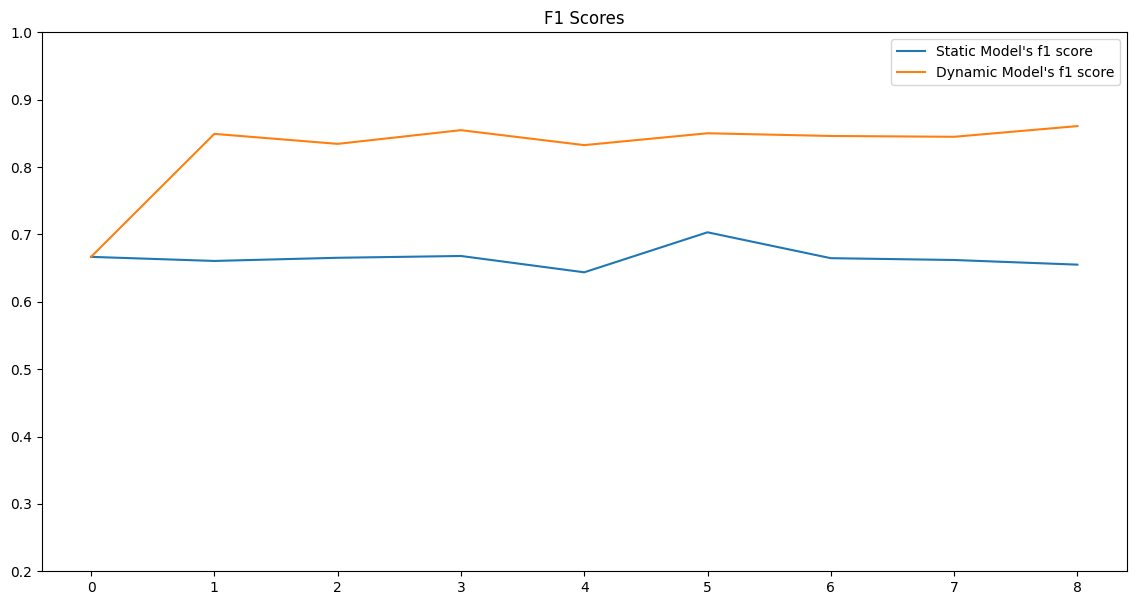

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(f1_static)), f1_static, label="Static Model's f1 score")
plt.plot(range(len(f1_dynamic)), f1_dynamic, label="Dynamic Model's f1 score")
plt.ylim(0.2, 1)
plt.title('F1 Scores')
plt.legend()
plt.show()

## Plotting Precision-Comparing static and dynamic models

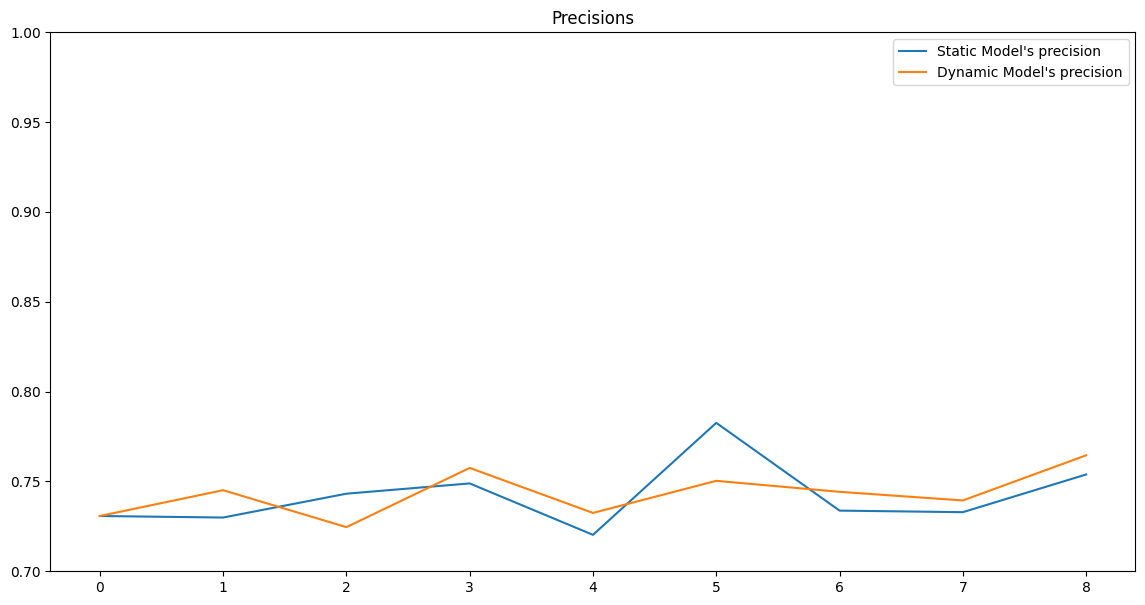

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(precision_static)), precision_static, label="Static Model's precision")
plt.plot(range(len(precision_dynamic)), precision_dynamic, label="Dynamic Model's precision")
plt.ylim(0.7, 1)
plt.title('Precisions')
plt.legend()
plt.show()

## Plotting Recall-Comparing static and dynamic models

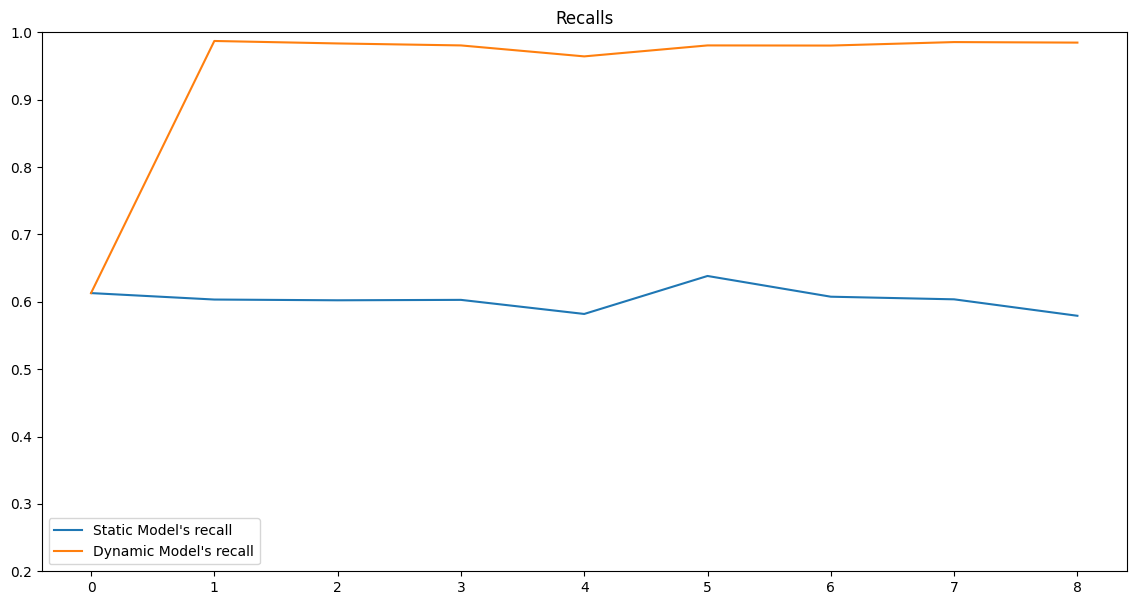

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(range(len(recall_static)), recall_static, label="Static Model's recall")
plt.plot(range(len(recall_dynamic)), recall_dynamic, label="Dynamic Model's recall")
plt.ylim(0.2, 1)
plt.title('Recalls')
plt.legend()
plt.show()